### Import Libraries

In [1]:
import re
import time
import random
import imageio
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.figure import Figure
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import glob
import librosa

### Feature Extraction

In [2]:
# DFT matrix to caluclate 64 point DFT from a 400-D signal
K, N = 64, 400
F = np.zeros((K,N), np.complex64)

for k in range(K):
    for n in range(N):
        F[k,n] =  np.exp(-2j *k * n * np.pi/N)




def spectrogram(x, win_len=400, hop_len=160, n_fft=256):
    '''
    spectrogram
    
    Inputs
    ------
    x: shape(N_f, ) - raw signal
    win_len: int - window length in frames
    hop_len: int - hop length in frames
    n_fft: int - number of fft points
    
    Returns
    -------
    xf: shape(N_f, 128) - spectrogram
    '''
    # calculate number of frames
    n_frames = 1 + np.int(np.floor((len(x) - win_len) / float(hop_len)))
    xf = np.zeros((n_frames, K), np.complex64)
    # perform sliding window operation
    for i in range(n_frames):
        z = x[i * hop_len: i * hop_len + win_len] * np.hamming(win_len)
        z2 = F @ z
        
        xf[i] = z2
    # obtain log of the absolute values of the features
    xf = np.log(np.abs(xf[:, :K // 2])+1e-8)                     
    return xf


def get_spec_frames(data_path):
    '''
    data_path: path to the .wav files

    returns
    -----
    frames: shape(*,32) ---> each row is a feature vector
    '''
    path = data_path
    dir_list  = glob.glob(data_path + '/*.wav')
    #print(len(dir_list))

    frames = []

    for i in range(len(dir_list)):
        y,fs = librosa.load(dir_list[i],sr = None)
        y_spec = spectrogram(y)
        frames.extend(y_spec)
            
    frames = np.array(frames)
    return frames



### K-MEANS

In [3]:
class KMeans:
    def __init__(self, n_clusters=2, max_iter=1000):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centers = None
        
    def dist(self, data_points, center):
        return np.sqrt(np.sum((data_points - center) ** 2, axis=1))
        
    def fit(self, data):
        # get initial centers from the samples itself.
        # better initializations are also available - have a look at kmeans++
        self.centers = data[
            np.random.choice(np.arange(len(data)), size=self.n_clusters)
        ]
        
        # kmeans algorithm
        for _ in range(self.max_iter):
            dist_matrix = np.zeros((len(data), self.n_clusters))
            for i in  range(self.n_clusters):
                dist_matrix[:, i] = self.dist(data, self.centers[i])
            cluster_assignment = dist_matrix.argmin(axis=1)
            # find new centers
            new_centers = np.zeros_like(self.centers)
            for i in range(self.n_clusters):
                new_centers[i] = np.mean(data[cluster_assignment == i], axis=0)
            # break if we have converged
            if np.allclose(new_centers, self.centers):
                self.centers = new_centers
                break
            self.centers = new_centers
        
    def predict(self, data):
        dist_matrix = np.zeros((len(data), self.n_clusters))
        for i in range(self.n_clusters):
            dist_matrix[:, i] = self.dist(data, self.centers[i])
        cluster_assignment = dist_matrix.argmin(axis=1)
        return cluster_assignment

### GMM

In [4]:
class GMM:
    def __init__(
        self, 
        n_mixtures=2, 
        max_iter=100, 
        covar_type='full', 
        plot_progress=False, 
        p_iter=5,
        gif_name='EM_Progress.gif'
    ):
        self.n_mixtures = n_mixtures
        self.max_iter = max_iter
        self.alphas = np.ones(n_mixtures) / n_mixtures
        self.means = None
        self.covs = None
        self.covar_type = covar_type
        self.plot_progress = plot_progress
        self.p_iter = p_iter
        self.gif_name = gif_name
        self.log_likelihood_plot_list = None
        self.cluster_idx = None
        
    def p(self, data, mean, cov):
        dist = multivariate_normal(mean=mean, cov=cov)
        return dist.pdf(data)
    
    def predict(self, data):
        posteriors = np.zeros((len(data), self.n_mixtures))
        for i in range(self.n_mixtures):
            posteriors[:, i] = self.alphas[i] * self.p(data, self.means[i], self.covs[i])
        labels = np.argmax(posteriors, axis=1)
        self.cluster_idx = labels
        return labels
    
    def full_covar(self, data, resp):
        new_covs = np.zeros_like(self.covs)
        for i in range(self.n_mixtures):
            diff = data - self.means[i]
            new_covs[i] = np.dot(resp[:, i] * diff.T, diff) / resp[:, i].sum()
            # regularization term to keep the covariance matrix positive semi-definite
            new_covs[i].flat[::data.shape[1] + 1] += 1e-6
        return new_covs
            
    def diag_covar(self, data, resp):
        sqrd_data = np.dot(resp.T, data * data) / resp.sum(axis=0)[:, None]
        sqrd_means = self.means ** 2
        means = self.means * np.dot(resp.T, data) / resp.sum(axis=0)[:, None]
        diag_covs = (sqrd_data - 2 * means + sqrd_means + 1e-6)
        new_covs = [np.diag(cov) for cov in diag_covs]
        return new_covs

    def get_log_likelihood(self, data):
        probs = np.zeros((len(data), self.n_mixtures))
        for i in range(self.n_mixtures):
            probs[:, i] = self.alphas[i] * self.p(data, self.means[i], self.covs[i])

        ll_hood = np.sum(np.log(probs.sum(axis=1)))

        return ll_hood
    
    def e_step(self, data):
        resp = np.zeros((len(data), self.n_mixtures))
        # find responsibility of each data point towards a Gaussian
        for i in range(self.n_mixtures):
            resp[:, i] = self.alphas[i] * self.p(data, self.means[i], self.covs[i])
            
        self.log_likelihood_plot_list.append(np.sum(np.log(resp.sum(axis=1)))) 
        # normalize the sum
        resp = resp / resp.sum(axis=1)[:, None]
        return resp
        
    def m_step(self, data, resp):        
        # re-estimation for alphas
        new_alphas = resp.mean(axis=0)
        
        # re-estimation for means
        new_means = np.zeros_like(self.means)
        for i in range(self.n_mixtures):
            new_means[i] = np.multiply(resp[:, i][:, None], data).sum(axis=0) / resp[:, i].sum()
        
        # re-estimation for covariance matrix
        if self.covar_type == 'full':
            new_covs = self.full_covar(data, resp)
        elif self.covar_type == 'diag':
            new_covs = self.diag_covar(data, resp)
        else:
            raise NotImplementedError()
            
        return new_alphas, new_means, new_covs
    
    def plot_creator(self, data):
        labels = self.predict(data)
        
        # create figure
        fig = Figure(figsize=(10, 8))
        canvas = FigureCanvas(fig)
        ax = fig.add_subplot(111)
        for i in range(self.n_mixtures):
            ax.scatter(data[:,0][labels == i], data[:, 1][labels == i], s=12, label='GMM-'+str(i))
        ax.set_xlabel('comp-1')
        ax.set_ylabel('comp-2')
        ax.set_title('Progress of EM Algorithm')
        ax.legend()
        fig.dpi = 200
        canvas.draw()
        image = np.asarray(canvas.buffer_rgba())
        return image
        
        
    def fit(self, data):
        n_features = data.shape[1]
        # intialize empty lists to store images and 
        # progress of EM algorithm per step
        progress_images = []
        self.log_likelihood_plot_list = []
        
        # initialize means
        kmeans_model = KMeans(n_clusters=self.n_mixtures)
        kmeans_model.fit(data)
        self.means = kmeans_model.centers
        
        # initialize cov
        self.covs = np.zeros((self.n_mixtures, n_features, n_features))
        data_labels = kmeans_model.predict(data)
        for i in range(self.n_mixtures):
            self.covs[i] = np.cov(data[data_labels == i].T)
        
        # EM - algorithm
        for step in range(self.max_iter):
            # for each data point find its responsibility
            # towards each gaussian
            resp = self.e_step(data)
            
            # re-estimation of model parameters
            alphas, means, covs = self.m_step(data, resp)
            
            # display progress after every 5 iterations
            if step % self.p_iter == 0 and self.plot_progress:
                progress_images.append(self.plot_creator(data))
            
            # break if convergence
            if np.allclose(self.alphas, alphas, rtol=1e-3, atol=1e-3) and \
               np.allclose(self.means, means, rtol=1e-3, atol=1e-3) and \
               np.allclose(self.covs, covs, rtol=1e-3, atol=1e-3):
               print('Converged after {}-th step'.format(step))
               break
                
            self.alphas = alphas
            self.means = means
            self.covs = covs
        
        self.log_likelihood_plot_list = self.log_likelihood_plot_list[1:]
        
        if self.plot_progress: 
            imageio.mimsave(self.gif_name, progress_images)
            

### Load train files and extract the feature vectors

In [5]:
# Put your own paths for train/music and train/speech dirs

music_train_path = './speech_music_classification/train/music/'
speech_train_path  = './speech_music_classification/train/speech/'

music_frames = get_spec_frames(music_train_path)
print('music_frames:', music_frames.shape)
speech_frames = get_spec_frames(speech_train_path)
print('speech_frames:',speech_frames.shape)



music_frames: (119920, 32)
speech_frames: (119920, 32)


## Train GMM for each class

In [6]:
# Put the number of mixture components and covrariance matrix type: {'diag','full'} here. 

num_components = 2
covar_type = 'diag'

#### Fit Music data

In [7]:

music_model = GMM(n_mixtures=num_components, covar_type=covar_type) 
music_model.fit(music_frames)



Converged after 9-th step


Text(0.5, 1.0, 'Log-likelihood')

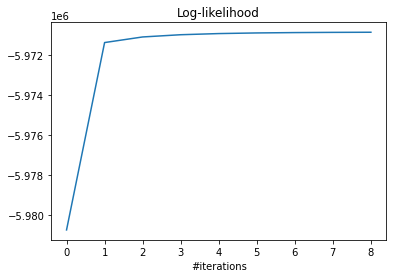

In [8]:
# Plot the log likelihood for music model
plt.plot(music_model.log_likelihood_plot_list)
plt.xlabel('#iterations')
plt.title('Log-likelihood')

#### Fit speech data 

In [9]:
speech_model = GMM(n_mixtures=num_components, covar_type=covar_type)
speech_model.fit(speech_frames)


Converged after 8-th step


Text(0.5, 1.0, 'Log-likelihood')

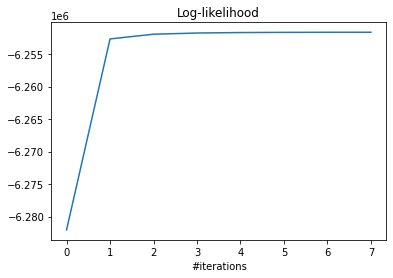

In [10]:
# Plot the log likelihood for speech model
plt.plot(speech_model.log_likelihood_plot_list)
plt.xlabel('#iterations')
plt.title('Log-likelihood')

## Testing
#### Load the test files and generate labels

In [11]:
test_path = './speech_music_classification/test/'
label_dict = {'speech':0, 'music':1}

test_labels = []
test_dir_list = glob.glob(test_path + '*.wav')
for i in range(len(test_dir_list)):
    f = test_dir_list[i]
    label_str = f.split('/')[-1].split('_')[0]
    test_labels.append(label_dict[label_str])

print('First few test files:\n\n', test_dir_list[0:40:4],'\n\n')
print('First few test labels:\n\n', test_labels[0:40:4])


First few test files:

 ['./speech_music_classification/test/speech_2.wav', './speech_music_classification/test/speech_15.wav', './speech_music_classification/test/music_12.wav', './speech_music_classification/test/speech_7.wav', './speech_music_classification/test/music_2.wav', './speech_music_classification/test/speech_19.wav', './speech_music_classification/test/speech_8.wav', './speech_music_classification/test/speech_5.wav', './speech_music_classification/test/music_23.wav', './speech_music_classification/test/speech_20.wav'] 


First few test labels:

 [0, 0, 1, 0, 1, 0, 0, 0, 1, 0]


In [12]:
# predict

pred_labels = []
for i in range(len(test_dir_list)):

    y,sr = librosa.load(test_dir_list[i], sr=None)
    y_spec = spectrogram(y)
    #print(y_spec.shape)

    ll_speech = speech_model.get_log_likelihood(y_spec)
    ll_music = music_model.get_log_likelihood(y_spec)
    pred_label = 0 if ll_speech > ll_music else 1
    pred_labels.append(pred_label)

test_labels = np.array(test_labels)
pred_labels = np.array(pred_labels)

In [13]:
# Calculate error rate

correct = (test_labels == pred_labels).sum()
print('Number of correctly classified examples: {}, out of {} test samples'.format(correct, len(test_dir_list)))
accuracy = 100. * correct / len(test_dir_list)
print('error rate: ', 100 - accuracy)

Number of correctly classified examples: 43, out of 48 test samples
error rate:  10.416666666666671


### Observations:
#### a) As number of mixture components increases, the mixture of Gaussians better approximates the data distribution. So we see decrease in error rate. 
#### b) Adjacent samples of speech and music signals are very much correlated. These correlations manifest themselves as varying maginitude spectrum of the windowed signal. Diagonal covariance matrix can't capture these relations among the feature components. Thus a higher error rate. 

### Note:
#### Here the classification is done based on log-likelihood of the spectrogram assuming its feature frames are independently drawn. Another criteria would be to use majority count over predicted labels of the feature vectors. 
 